In [1]:
using Plots
import Pkg; Pkg.add("DataFrames")
using DataFrames
using Statistics
using Plots
import Pkg; Pkg.add("PlotlyJS")
using Pkg
Pkg.add("IJulia")
import Pkg; Pkg.add("PyPlot")


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [2]:
function add_noise(value::Float64, noise_level::Float64)
    return value + (randn()*2-1) * noise_level
end

add_noise (generic function with 1 method)

In [7]:
function calc_MAE(v::Float64, v_hat::Float64)
    return mean(abs(v - v_hat))
end

calc_MAE (generic function with 2 methods)

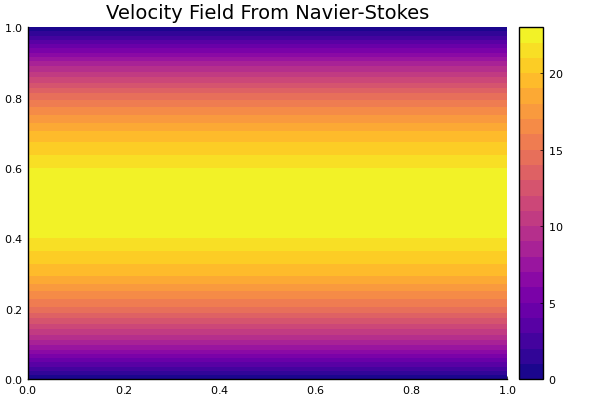

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [9]:
using LinearAlgebra
using Plots
pyplot()

N_POINTS = 11
KINEMATIC_VISCOSITY = 0.01
TIME_STEP_LENGTH = 0.1
N_TIME_STEPS = 500
PRESSURE_GRADIENT = [-1.0, 0.0]
 
element_length = sqrt(2) / (N_POINTS - 1)
x_range = range(0.0, stop=1.0, length=N_POINTS)
y_range = range(0.0, stop=1.0, length=N_POINTS)

coordinates_x = [x for x in x_range, y in y_range]
coordinates_y = [y for x in x_range, y in y_range]

function central_difference_x_periodic(field, element_length)
    diff = (circshift(field, (0, 1)) - circshift(field, (0, -1))) / (2 * element_length)
    return diff
end

function laplace_periodic(field, element_length)
    diff = (circshift(field, (0, 1)) + circshift(field, (1, 0)) +
            circshift(field, (0, -1)) + circshift(field, (-1, 0)) -
            4 * field) / element_length^2
    return diff
end

velocity_x_prev = ones(N_POINTS, N_POINTS)
velocity_x_prev[1, :] .= 0.0
velocity_x_prev[end, :] .= 0.0
velocity_x_final = copy(velocity_x_prev)

for iter in 1:N_TIME_STEPS
    convection_x = velocity_x_prev .* central_difference_x_periodic(velocity_x_prev, element_length)
    diffusion_x = KINEMATIC_VISCOSITY * laplace_periodic(velocity_x_prev, element_length)

    velocity_x_next = velocity_x_prev .+ TIME_STEP_LENGTH * (-PRESSURE_GRADIENT[1] .+ diffusion_x .- convection_x)

    velocity_x_next[1, :] .= 0.0  
    velocity_x_next[end, :] .= 0.0 
    if iter == N_TIME_STEPS
        velocity_x_final .= velocity_x_next
    end
    velocity_x_prev = velocity_x_next
end

p5 = contourf(coordinates_y, coordinates_x, velocity_x_final, levels=25, title="Velocity Field From Navier-Stokes", color=:plasma)
plot(p5, layout=(1,1))

In [37]:
#Aplicando modelo ao vetor de velocidades

In [10]:
function transit_time_at_point_up(velocity, element_length, speed_of_sound)
    angle_factor = cos(π / 4)
    time = (element_length / (speed_of_sound - (velocity * angle_factor)))
    return time
end

function transit_time_at_point_down(velocity, element_length, speed_of_sound)
    angle_factor = cos(π / 4)
    time = (element_length / (speed_of_sound + (velocity * angle_factor)))
    return time
end

transit_time_at_point_down (generic function with 1 method)

In [17]:
beam_path = []
row = 1
col = 1
while row >= 0 && row <= N_POINTS && col >= 0 && col <= N_POINTS
    push!(beam_path,copy(velocity_x_final[row,col]))
    row = row+1
    col = col+1
end

beam_times_down = []
beam_times_up = []
SPEED_OF_SOUND = 1450
L = sqrt(2)
element_length = L / (N_POINTS - 1)


for i in 1:N_POINTS
    push!(beam_times_down,copy(transit_time_at_point_down(beam_path[i],element_length,SPEED_OF_SOUND)))
    push!(beam_times_up,copy(transit_time_at_point_up(beam_path[i],element_length,SPEED_OF_SOUND)))
end

total_transit_time_up = reduce(+, beam_times_up)
total_transit_time_down = reduce(+, beam_times_down)

#print(beam_times_down)

println("Total transit time  up along the 45-degree path: $total_transit_time_up seconds")
println("Total transit time down along the 45-degree path: $total_transit_time_down seconds")

delta_t = total_transit_time_up - total_transit_time_down
product_t = total_transit_time_up * total_transit_time_down
v_calculated = (L*delta_t)/(2*cos(π / 4)*product_t)
v_calculated = add_noise(v_calculated,0.05)
println("Velocity measured along the 45-degree path: $v_calculated")
println("Mean of the field: $(mean(velocity_x_final))")
println("MAE: $(calc_MAE(mean(velocity_x_final),v_calculated))")

Total transit time  up along the 45-degree path: 0.0010801314557242014 seconds
Total transit time down along the 45-degree path: 0.0010657022776228383 seconds
Velocity measured along the 45-degree path: 12.50683538864676
Mean of the field: 13.78850919014791
MAE: 1.2816738015011495
